In [408]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Concatenate, Lambda
from tensorflow.keras.models import Model
import pandas as pd

In [409]:
df_bon=pd.read_csv('true.csv')
df_mauvais=pd.read_csv('false.csv')
df_mitm=pd.read_csv('vols_reconstruits_filtrés.csv')
df_mitm=df_mitm.drop(columns=['snow','erreur_m'],axis=1)
df_mauvais=df_mauvais.drop(columns=['snow','erreur_m'],axis=1)
df_bon=df_bon.drop(columns=['erreur_m','snow'],axis=1)

In [410]:
df_bon['real_y'].min()

np.float64(-7.999999999999998)

In [411]:
#df_mitm['is_attack'] = df_mitm["is_attack"].replace(1, 2)

In [412]:
seuil = 6

df_bon.loc[abs(df_bon['real_y']) >seuil, 'real_y'] = 5.5

In [413]:
seuil = 12

df_bon.loc[abs(df_bon['real_y']) >seuil, 'real_y'] = 11.5

In [414]:
df_merge = pd.concat([df_bon, df_mauvais,df_mitm], ignore_index=True)
df_merge.shape
df_merge.describe()


,mission_id,time,real_x,real_y,real_z,vx,vy,vz,ax,ay,...,roll,pitch,yaw,wind_x,wind_y,wind_z,velocity,rain,fog,is_attack
count,14763.000000,1.476300e+04,14763.000000,14763.000000,14763.000000,14763.000000,14763.000000,14763.000000,14763.000000,14763.000000,...,14763.000000,14763.000000,14763.000000,14763.000000,14763.000000,14763.000000,14763.000000,14763.000000,14763.000000,14763.000000
mean,338.004267,1.660058e+09,18.255141,0.538476,-2.877110,0.293210,0.101049,0.139440,-0.058603,-0.504637,...,-0.011263,-0.024501,-0.171638,2.948753,1.923604,1.358679,12.521068,0.105919,0.108627,0.637743
std,310.059015,3.800015e+08,15.439048,3.468273,4.291379,2.205532,1.165419,0.619086,0.181904,2.144007,...,0.123615,0.525968,2.482382,0.339315,0.412904,5.194177,43.952202,0.063031,0.074061,0.480669
min,1.000000,-5.240803e+00,-12.084674,-14.119663,-36.765549,-9.472232,-6.753105,-3.540250,-7.257311,-11.851079,...,-0.772978,-3.131726,-3.141575,1.500462,0.400274,0.060624,0.089348,0.000000,0.000000,0.000000
25%,99.000000,1.745441e+09,4.039461,-1.000000,-5.000000,-0.225025,-0.209575,-0.026690,-0.086344,-0.065334,...,-0.062941,-0.027031,-2.760905,2.777819,1.771260,0.453322,4.760000,0.060000,0.051000,0.000000
50%,248.000000,1.747511e+09,16.006756,0.000000,-4.990730,0.285793,0.017191,0.018173,-0.034524,-0.019611,...,-0.000085,0.000010,-0.588664,2.980671,1.976061,0.505194,6.100000,0.100000,0.106000,1.000000
75%,506.000000,1.747771e+09,31.634746,2.539721,-1.714233,0.618171,0.446627,0.678755,0.012818,0.022720,...,0.006116,0.016920,2.660495,3.173305,2.174112,0.556939,7.990000,0.160000,0.157000,1.000000
max,1305.000000,1.747930e+09,70.000000,18.104100,19.517063,9.613590,6.377484,15.107558,0.372367,9.114528,...,0.827115,3.138979,3.498398,3.499988,2.499987,150.911467,711.678817,0.380000,0.492000,1.000000


In [415]:
df_merge.shape

(14763, 21)

In [416]:
df_merge.isna().sum()

mission_id    0
time          0
real_x        0
real_y        0
real_z        0
vx            0
vy            0
vz            0
ax            0
ay            0
az            0
roll          0
pitch         0
yaw           0
wind_x        0
wind_y        0
wind_z        0
velocity      0
rain          0
fog           0
is_attack     0
dtype: int64

In [417]:
X=df_merge.drop(columns=['is_attack'],axis=1)
Y=df_merge['is_attack']

In [418]:
seuil = 0
mediane = df_merge['vz'].median()

df_merge.loc[df_merge['vz'] ==seuil, 'vz'] = mediane

In [419]:
seuil = 0
mediane = df_merge['vy'].median()

df_merge.loc[df_merge['vy'] ==seuil, 'vy'] = mediane

In [420]:
seuil = 0
mediane = df_merge['vx'].median()

df_merge.loc[df_merge['vx'] ==seuil, 'vx'] = mediane

In [421]:
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
import tensorflow as tf

# Ta couche personnalisée (inchangée)
class ScaledActivatedDense(Layer):
    def __init__(self, units, activation='relu', name_prefix="", **kwargs):
        super(ScaledActivatedDense, self).__init__(**kwargs)
        self.units = units
        self.activation_fn = tf.keras.activations.get(activation)
        self.name_prefix = name_prefix

    def build(self, input_shape):
        self.dense = Dense(self.units, activation=None, use_bias=True)
        self.a = self.add_weight(
            name=f"{self.name_prefix}_scales",
            shape=(self.units,),
            initializer="ones",
            trainable=True
        )

    def call(self, inputs):
        x = self.dense(inputs)
        x = self.activation_fn(x)
        return self.a * x


In [422]:

timesteps = 7
features_per_step = 20
input_layer = Input(shape=(timesteps, features_per_step), name="input")

# Étape 1 : réduire par moyenne globale les 3 pas de temps
x = GlobalAveragePooling1D()(input_layer)  # devient (batch_size, features_per_step)

# Étape 2 : MLP profond
x = BatchNormalization()(x)
x = ScaledActivatedDense(256, activation='relu', name_prefix="dense1")(x)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)
x = ScaledActivatedDense(128, activation='relu', name_prefix="dense2")(x)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)
x = ScaledActivatedDense(64, activation='relu', name_prefix="dense3")(x)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)
output = Dense(1, activation='sigmoid', name="output")(x)

# Création du modèle
model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()   

Model: "functional_51"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 7, 20)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_16     │ (None, 20)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_120         │ (None, 20)             │            80 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ scaled_activated_dense_57       │ (None, 256)            │         5,632 │
│ (ScaledActivatedDense)          │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_106 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_121         │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ scaled_activated_dense_58       │ (None, 128)            │        33,024 │
│ (ScaledActivatedDense)          │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_107 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_122         │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ scaled_activated_dense_59       │ (None, 64)             │         8,320 │
│ (ScaledActivatedDense)          │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_108 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_123         │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 48,913 (191.07 KB)

 Trainable params: 47,977 (187.41 KB)

 Non-trainable params: 936 (3.66 KB)

In [423]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [424]:
X = X_scaled.to_numpy()[:2109* 7].reshape(2109, 7, 20)
print(X)

[[[-1.06758863  0.22352052 -1.1867754  ... -0.05440339  4.03117451
    0.97724191]
  [-1.06758863  0.22352055 -1.04684693 ... -0.05440339  4.03117451
    0.97724191]
  [-1.06758863  0.22352056 -0.89988247 ... -0.05440339  4.03117451
    0.97724191]
  ...
  [-1.06758863  0.22352057 -0.65022409 ... -0.05440339  4.03117451
    0.97724191]
  [-1.06758863  0.22352058 -0.53150235 ... -0.05440339  4.03117451
    0.97724191]
  [-1.06758863  0.22352059 -0.4010501  ... -0.05440339  4.03117451
    0.97724191]]

 [[-1.06758863  0.22352059 -0.27838216 ... -0.05440339  4.03117451
    0.97724191]
  [-1.06758863  0.2235206  -0.14790674 ... -0.05440339  4.03117451
    0.97724191]
  [-1.06758863  0.2235206  -0.01936122 ... -0.05440339  4.03117451
    0.97724191]
  ...
  [-1.06758863  0.22352062 -0.03912343 ... -0.05440339  4.03117451
    0.97724191]
  [-1.06758863  0.22352062 -0.1443035  ... -0.05440339  4.03117451
    0.97724191]
  [-1.06758863  0.22352062 -0.27105392 ... -0.05440339  4.03117451
    0.

In [425]:
nb_lignes = len(Y)
vol_length = 7
nb_vols = nb_lignes // vol_length
y = Y.to_numpy().reshape(nb_vols, 7)
y_vol = y[:, 0:1]
print(y_vol.shape)

(2109, 1)


In [426]:
y = y_vol.reshape(-1, 1)
print(X.shape)


(2109, 7, 20)


In [427]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [428]:
import time
sart_time = time.time()
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)
end_time = time.time()


loss, accuracy = model.evaluate(X_test, y_test)
print("Training time : ",end_time - sart_time)

Epoch 1/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.5427 - loss: 0.8347 - val_accuracy: 0.7219 - val_loss: 0.5872
Epoch 2/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6561 - loss: 0.6318 - val_accuracy: 0.7278 - val_loss: 0.5436
Epoch 3/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7198 - loss: 0.5671 - val_accuracy: 0.7456 - val_loss: 0.5173
Epoch 4/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7299 - loss: 0.5290 - val_accuracy: 0.7515 - val_loss: 0.4951
Epoch 5/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7766 - loss: 0.4904 - val_accuracy: 0.7722 - val_loss: 0.4611
Epoch 6/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7665 - loss: 0.4723 - val_accuracy: 0.7899 - val_loss: 0.4460
Epoch 7/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7792 - loss: 0.4593 - val_accuracy: 0.7811 - val_loss: 0.4308
Epoch 8/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7564 - loss: 0.4954 - val_accuracy: 0.7899 - 

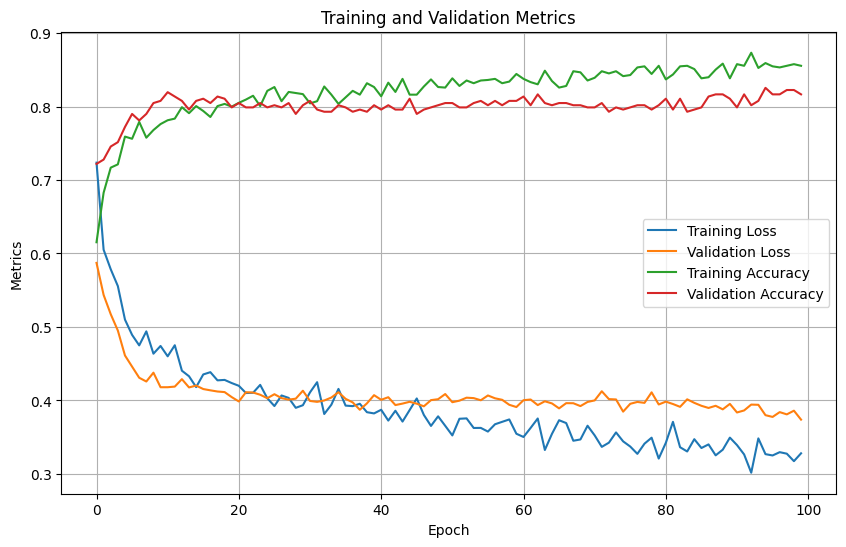

In [429]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Metrics')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.legend()
plt.grid(True)
plt.show()

In [430]:
y_pred_proba = model.predict(X_test)
y_pred_classes = (y_pred_proba > 0.5).astype(int)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [431]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_test, y_pred_classes))

              precision    recall  f1-score   support

         0.0       0.83      0.65      0.73       153
         1.0       0.82      0.93      0.87       269

    accuracy                           0.82       422
   macro avg       0.83      0.79      0.80       422
weighted avg       0.83      0.82      0.82       422



In [432]:
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed, BatchNormalization
from tensorflow.keras.models import Sequential
model2 = Sequential([
    LSTM(units=256, input_shape=(7, 20), return_sequences=True),
    BatchNormalization(),
    Dropout(0.3),
    LSTM(units=128, return_sequences=False),
    Dropout(0.3),
    BatchNormalization(),
    Dense(units=1, activation='sigmoid')
])
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

sart_time = time.time()
history = model2.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

end_time = time.time()


loss, accuracy = model2.evaluate(X_test, y_test)
print("Training time : ",end_time - sart_time)

Epoch 1/100


c:\Users\NITRO\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.6778 - loss: 0.6763 - val_accuracy: 0.7160 - val_loss: 0.5774
Epoch 2/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7762 - loss: 0.4746 - val_accuracy: 0.7633 - val_loss: 0.5275
Epoch 3/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8061 - loss: 0.4268 - val_accuracy: 0.7219 - val_loss: 0.5147
Epoch 4/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7990 - loss: 0.4173 - val_accuracy: 0.7751 - val_loss: 0.4797
Epoch 5/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8388 - loss: 0.3486 - val_accuracy: 0.7929 - val_loss: 0.4350
Epoch 6/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8360 - loss: 0.3369 - val_accuracy: 0.8018 - val_loss: 0.4361
Epoch 7/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8486 - loss: 0.3248 - val_accuracy: 0.7959 - val_loss: 0.4307
Epoch 8/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8579 - loss: 0.3208 - val_accuracy: 0.7929 - val_l

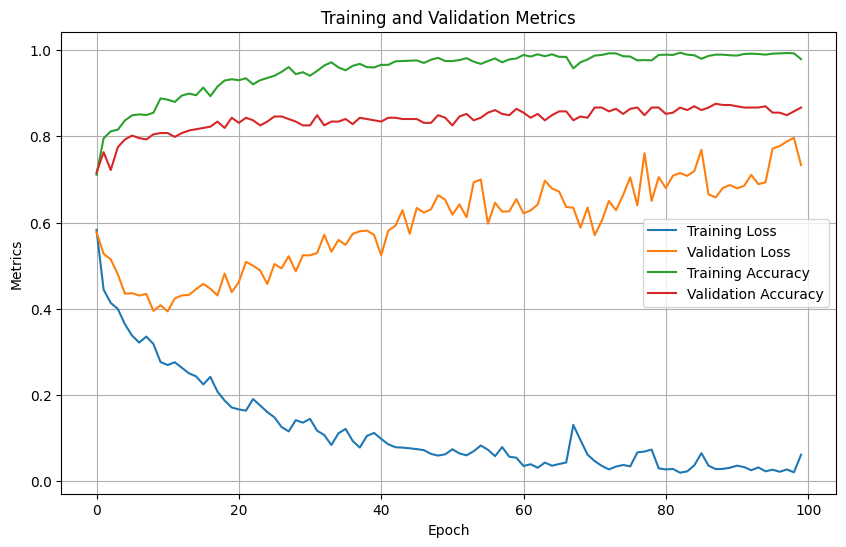

In [433]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Metrics')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.legend()
plt.grid(True)
plt.show()

In [434]:
y_pred_proba = model2.predict(X_test)
y_pred_classes = (y_pred_proba > 0.5).astype(int)

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


In [435]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_test, y_pred_classes))

              precision    recall  f1-score   support

         0.0       0.88      0.76      0.81       153
         1.0       0.87      0.94      0.91       269

    accuracy                           0.87       422
   macro avg       0.88      0.85      0.86       422
weighted avg       0.87      0.87      0.87       422



In [436]:
from tensorflow.keras.layers import Layer, ReLU

class ScaledReLU(Layer):
    def __init__(self, name_prefix, **kwargs):
        super(ScaledReLU, self).__init__(**kwargs)
        self.name_prefix = name_prefix
        self.relu = ReLU()

    def build(self, input_shape):
        self.a = self.add_weight(name=f"{self.name_prefix}_a",
                                 shape=(),
                                 initializer="ones",
                                 trainable=True)

    def call(self, inputs):
        return self.a * self.relu(inputs)

In [437]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Concatenate, Lambda
from tensorflow.keras.models import Model

# Hypothèses
timesteps = 7       # 21 étapes temporelles
features_per_step = 20 

features_input = Input(shape=(timesteps, features_per_step), name='X')


activation = Lambda(lambda x: tf.zeros_like(x[:, :1,0]))(features_input)
a = tf.Variable(initial_value=1.0, trainable=True, dtype=tf.float32, name="learnable_scalar")
print(activation.shape)
activations=[]
for t in range(timesteps):
    step_features = Lambda(lambda x: x[:, t])(features_input) 
    combined_input = Concatenate(axis=1)([step_features, activation])  # (batch_size, 18+1)
    
   
    neuron_output = Dense(1, activation='sigmoid', name=f'neuron_{t+1}')(combined_input)
    scaled_relu = ScaledReLU(name_prefix=f't{t+1}')(neuron_output)
    activation = scaled_relu
    activations.append(scaled_relu)
   

final_output = Dense(1, activation='sigmoid')(activation)


model3 = Model(inputs=features_input, outputs=final_output)


model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])  # regression : MSE/MAE


model3.summary()

(None, 1)


Model: "functional_53"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ X (InputLayer)      │ (None, 7, 20)     │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_81 (Lambda)  │ (None, 20)        │          0 │ X[0][0]           │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_80 (Lambda)  │ (None, 1)         │          0 │ X[0][0]           │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_70      │ (None, 21)        │          0 │ lambda_81[0][0],  │
│ (Concatenate)       │                   │            │ lambda_80[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ neuron_1 (Dense)    │ (None, 1)         │         22 │ concatenate_70[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_82 (Lambda)  │ (None, 20)        │          0 │ X[0][0]           │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ scaled_re_lu_70     │ (None, 1)         │          1 │ neuron_1[0][0]    │
│ (ScaledReLU)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_71      │ (None, 21)        │          0 │ lambda_82[0][0],  │
│ (Concatenate)       │                   │            │ scaled_re_lu_70[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ neuron_2 (Dense)    │ (None, 1)         │         22 │ concatenate_71[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_83 (Lambda)  │ (None, 20)        │          0 │ X[0][0]           │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ scaled_re_lu_71     │ (None, 1)         │          1 │ neuron_2[0][0]    │
│ (ScaledReLU)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_72      │ (None, 21)        │          0 │ lambda_83[0][0],  │
│ (Concatenate)       │                   │            │ scaled_re_lu_71[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ neuron_3 (Dense)    │ (None, 1)         │         22 │ concatenate_72[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_84 (Lambda)  │ (None, 20)        │          0 │ X[0][0]           │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ scaled_re_lu_72     │ (None, 1)         │          1 │ neuron_3[0][0]    │
│ (ScaledReLU)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_73      │ (None, 21)        │          0 │ lambda_84[0][0],  │
│ (Concatenate)       │                   │            │ scaled_re_lu_72[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ neuron_4 (Dense)    │ (None, 1)         │         22 │ concatenate_73[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_85 (Lambda)  │ (None, 20)        │          0 │ X[0][0]           │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ scaled_re_lu_73     │ (None, 1)         │          1 │ neuron_4[0][0]    │
│ (ScaledReLU)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_74      │ (None, 21)        │          0 │ lambda_85[0][0],  │
│ (Concatenate)       │                   │            │ scaled_re_lu_73[… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 163 (652.00 B)

 Trainable params: 163 (652.00 B)

 Non-trainable params: 0 (0.00 B)

In [438]:
sart_time = time.time()
history = model3.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

end_time = time.time()


loss, accuracy = model3.evaluate(X_test, y_test)
print("Training time : ",end_time - sart_time)

Epoch 1/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.3474 - loss: 0.8843 - val_accuracy: 0.3728 - val_loss: 0.8304
Epoch 2/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3495 - loss: 0.8472 - val_accuracy: 0.3728 - val_loss: 0.7982
Epoch 3/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3480 - loss: 0.8087 - val_accuracy: 0.3639 - val_loss: 0.7709
Epoch 4/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3441 - loss: 0.7789 - val_accuracy: 0.3698 - val_loss: 0.7487
Epoch 5/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3234 - loss: 0.7529 - val_accuracy: 0.3757 - val_loss: 0.7300
Epoch 6/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3527 - loss: 0.7305 - val_accuracy: 0.3964 - val_loss: 0.7145
Epoch 7/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4058 - loss: 0.7179 - val_accuracy: 0.4556 - val_loss: 0.7016
Epoch 8/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4471 - loss: 0.7036 - val_accuracy: 0.4970 - 

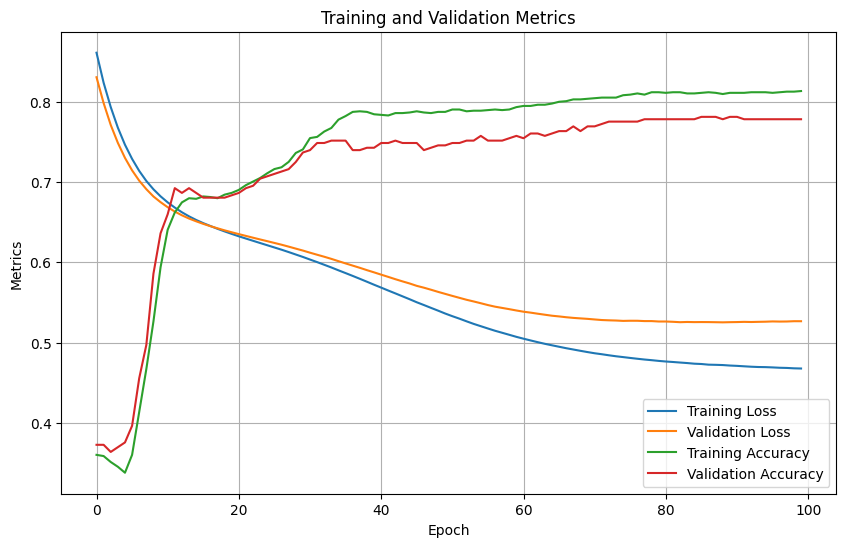

In [439]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Metrics')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.legend()
plt.grid(True)
plt.show()

In [440]:
y_pred_proba = model3.predict(X_test)
y_pred_classes = (y_pred_proba > 0.5).astype(int)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [441]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_test, y_pred_classes))

              precision    recall  f1-score   support

         0.0       0.82      0.44      0.57       153
         1.0       0.75      0.94      0.83       269

    accuracy                           0.76       422
   macro avg       0.78      0.69      0.70       422
weighted avg       0.77      0.76      0.74       422



In [442]:
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed, BatchNormalization
from tensorflow.keras.models import Sequential
model4 = Sequential([
    LSTM(units=14, input_shape=(7, 20), return_sequences=True),
    BatchNormalization(),
    Dropout(0.3),
    LSTM(units=7, return_sequences=False),
    Dropout(0.3),
    BatchNormalization(),
    Dense(units=1, activation='sigmoid')
])
model4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

sart_time = time.time()
history = model4.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

end_time = time.time()


loss, accuracy = model4.evaluate(X_test, y_test)
print("Training time : ",end_time - sart_time)

Epoch 1/100


c:\Users\NITRO\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.5209 - loss: 0.7627 - val_accuracy: 0.6065 - val_loss: 0.6688
Epoch 2/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6047 - loss: 0.6707 - val_accuracy: 0.6568 - val_loss: 0.6365
Epoch 3/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6860 - loss: 0.6037 - val_accuracy: 0.7071 - val_loss: 0.6000
Epoch 4/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6942 - loss: 0.5843 - val_accuracy: 0.7396 - val_loss: 0.5664
Epoch 5/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7164 - loss: 0.5576 - val_accuracy: 0.7308 - val_loss: 0.5415
Epoch 6/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7481 - loss: 0.5319 - val_accuracy: 0.7633 - val_loss: 0.5182
Epoch 7/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7652 - loss: 0.5123 - val_accuracy: 0.7604 - val_loss: 0.5005
Epoch 8/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7677 - loss: 0.4961 - val_accuracy: 0.7663 - val_loss: 0.

In [443]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

mlp_model = Sequential([
    Flatten(input_shape=(7, 20)),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='softmax')
])

mlp_model.compile(
    optimizer=Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

c:\Users\NITRO\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
mlp_model.fit(X_train, y_train, epochs=50, batch_size=32,
              validation_data=(X_val, y_val),
)